### Imports

In [ ]:
### Uncomment and run this if you don't have the libaries already installed

# !pip install timm
# !pip install astropy
# !pip install albumentations

In [1]:
## Filter unwanted warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
from random import sample
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import timm
import torch
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split

## To read .fits files
import astropy
from astropy.io import fits
import tarfile

np.random.seed(10)
torch.manual_seed(10)

### Data Loading and Pre-Processing

In [2]:
## Extracting the files to required directory
f = tarfile.open('/kaggle/input/lens-finding/lens_finding.tgz')
f.extractall('/kaggle/working//Lens_finding/')

The extracted folder contains a subfolder "files" and a CSV file "classification.csv". The files folder contains images with and without strong lenses. The CSV files contains the numerical data about some of the features of the images. There is an ID column in the CSV file that can be used to map the images in the files folder with the csv data. The "is_lens" column tells whether the image is lens or not.

In [3]:
files = glob.glob('/kaggle/working/Lens_finding/SpaceBasedTraining/files/*')

In [4]:
len(files)

18000

The IDs of the images were there in the path itself, so I extracted the IDs of the images from their image paths and saved them into a list.

In [7]:
image_ids = []
for i in range(len(files)):
  id = files[i].split('imageEUC_VIS-')[-1].split(".fits")[0]
  image_ids.append(int(id))

Loaded the CSV file in pandas DataFrame

In [8]:
df = pd.read_csv('/kaggle/working/Lens_finding/SpaceBasedTraining/classifications.csv')
df

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.4290
1,100001,1,1.317890e-10,294,855.5890
2,100002,1,4.877250e-12,140,486.1130
3,100003,1,1.440160e-09,1500,10467.4000
4,100004,0,2.197350e-11,0,0.0000
...,...,...,...,...,...
17995,117995,1,4.428430e-11,35,68.9357
17996,117996,0,1.937930e-11,0,0.0000
17997,117997,1,5.505060e-11,520,1145.4500
17998,117998,1,9.624780e-12,109,434.6310


In [9]:
df.ID.dtype

dtype('int64')

Checking whether the total no. of images = total no. of rows in the DataFrame and making sure that there is no mismatch

In [10]:
df = df[df.ID.isin(image_ids)].reset_index(drop = True)

len(df) == len(files)

True

The more the data the better the performance of the model!! (Hopefully)

So, I added the images path to the DataFrame such that the image id and the ID column in the DataFrame matches

In [11]:
path = '/kaggle/working/Lens_finding/SpaceBasedTraining/files/imageEUC_VIS-'
df['image'] = [f"{path}{x}.fits" for x in df.ID]

In [12]:
df.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,image
0,100000,1,8.633760e-10,171,195.429,/kaggle/working/Lens_finding/SpaceBasedTrainin...
1,100001,1,1.317890e-10,294,855.589,/kaggle/working/Lens_finding/SpaceBasedTrainin...
2,100002,1,4.877250e-12,140,486.113,/kaggle/working/Lens_finding/SpaceBasedTrainin...
3,100003,1,1.440160e-09,1500,10467.400,/kaggle/working/Lens_finding/SpaceBasedTrainin...
4,100004,0,2.197350e-11,0,0.000,/kaggle/working/Lens_finding/SpaceBasedTrainin...


Checking for class imbalance and found that there are much more data of lens than there are of no lens

In [13]:
df['is_lens'].value_counts()

1    12574
0     5426
Name: is_lens, dtype: int64

During splitting I used an extra parameter "stratify", it makes sure that during splitting one class doesn't completely outweight the other class. Still it doesn't completely solve the class imbalance issue, but reduces it to some extent.

In [14]:
train, test = train_test_split(df, test_size=0.1, random_state=10, stratify=df['is_lens'])

train, val = train_test_split(train, test_size = 0.1, random_state=10, stratify=train['is_lens'])

In [15]:
print(train.shape, val.shape, test.shape)

(14580, 6) (1620, 6) (1800, 6)


no_lens -> 0

lens -> 1

In [16]:
label_2_idx_dict = {'no lens' : 0, 'lens' : 1}
idx_2_label_dict = {0 : 'no lens', 1 : 'lens'}

Images Plots

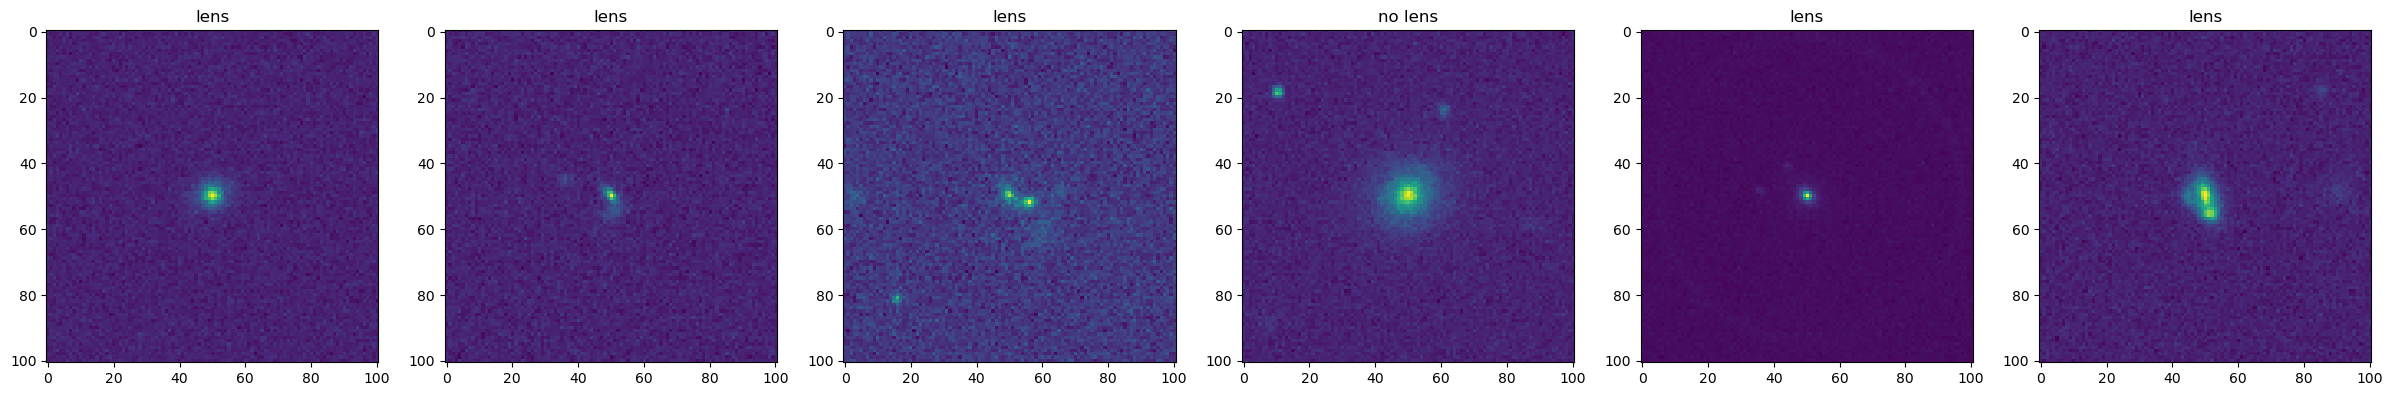

In [17]:
fig, ax = plt.subplots(1, 6)
fig.set_figheight(30)
fig.set_figwidth(30)
for i in range(6):
  idx = np.random.randint(0, train.shape[0])
  img_arr = fits.open(train.iloc[idx]['image'])
  ax[i].imshow(img_arr[0].data)
  title = idx_2_label_dict[train.iloc[idx]['is_lens']]
  ax[i].set_title(title)

There are 3 numerical features in the DataFrame, where all the values are not in scale. So I created a normalize function where I used the min-max scaling method to normalize each feature separately.

X_norm = (X - X_min) / (X_max - X_min)

In [18]:
features_column = ["Einstein_area" , "numb_pix_lensed_image" , "flux_lensed_image_in_sigma"]

def normalize(data):
  result = data.copy()
  for feature_name in features_column:
    max_value = data[feature_name].max()
    min_value = data[feature_name].min()
    
    result[feature_name] = (data[feature_name] - min_value) / (max_value - min_value)

  return result

In [19]:
train_df = normalize(train).reset_index(drop = True)
val_df = normalize(val).reset_index(drop = True)
test_df = normalize(test).reset_index(drop = True)

Creating the Dataset Class

I defined a custom dataset class called CreateDataset which inherits from the PyTorch Dataset class. It takes a pandas DataFrame and an optional transforms object as input. The len function returns the length of the DataFrame. The getitem function loads a FITS image using the astropy library, normalizes the image using max normalization, applies the provided transforms (if any), and returns a tuple containing the image tensor, feature tensor, and label tensor, which are all converted to PyTorch tensors.

In [20]:
class CreateDataset(Dataset):
  def __init__(self, df, transforms = None):
    self.df = df
    self.transforms = transforms

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    img = fits.open(self.df.iloc[idx]['image'])   ## used the astropy library here to load the images
    image = img[0].data.astype(np.float)
    image = image / np.max(image)  ## normalized the images

    if self.transforms:
      aug = self.transforms(image=image)
      image = aug['image']

    labels = torch.tensor(self.df['is_lens'][idx])
    features = torch.tensor(self.df[features_column].iloc[idx,:].values, dtype = torch.float)
    
    return image, features, labels

Augmentations

I have defined two different augmentations for the train and test sets. For the training set, I used horizontal and vertical flips, an advanced blur with various limits on blur and noise, and set the images to be transformed to tensors using ToTensorV2(). For the test set, I simply transformed the images to tensors using ToTensorV2().

In [21]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.AdvancedBlur(blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.7, 1), always_apply=False, p=0.3),
    ToTensorV2()
])

test_transform = A.Compose([
    ToTensorV2()
])

Checking if the CreateDataset function is working, also plotting to see the augmentations applied to the images

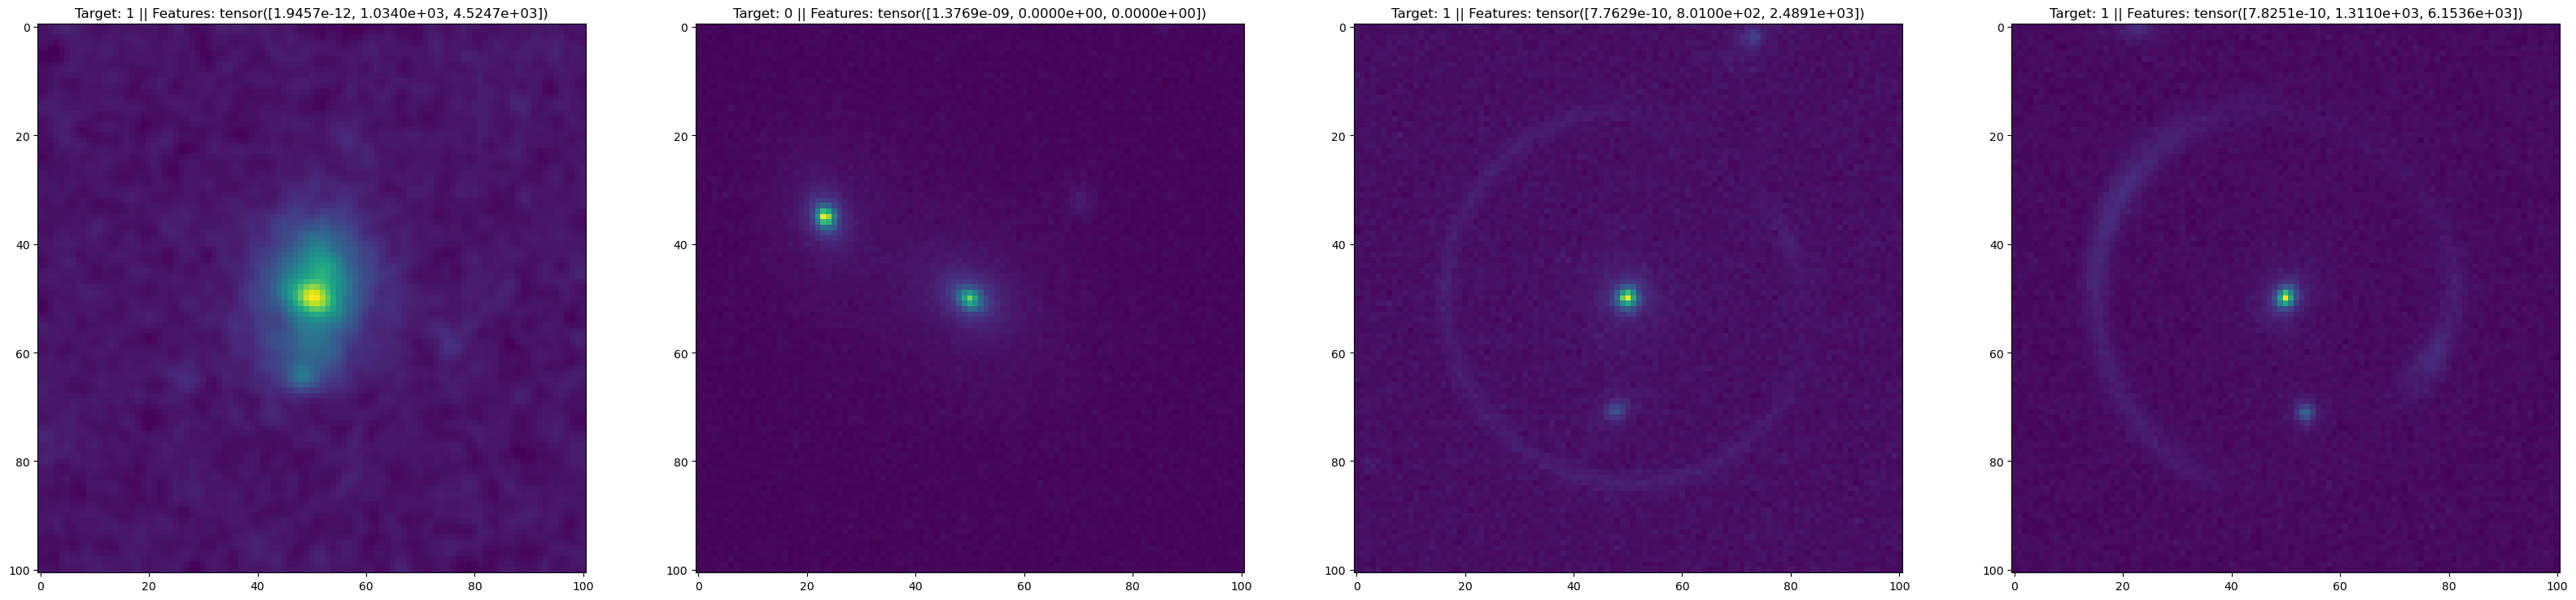

In [22]:
dummy_data = CreateDataset(train.reset_index(drop=True), transforms=train_transform)
dummy_loader = DataLoader(dummy_data,
                         shuffle=True,
                    batch_size=4)
a,b,c = next(iter(dummy_loader))

fig, ax = plt.subplots(1, 4)
fig.set_figheight(25)
fig.set_figwidth(40)
for i in range(4):
  idx = np.random.randint(0, train.shape[0])
  ax[i].imshow(a[i].squeeze(0))
  title = f"Target: {c[i]} || Features: {b[i]}"
  ax[i].set_title(title)

Forming the dataset

Pytorch standard DataLoader function, which creates PyTorch data loaders for the training, validation, and test datasets, which can be used to load batches of data for training or testing machine learning models.

In [23]:
train_ds = CreateDataset(train_df, transforms=train_transform)
val_ds = CreateDataset(val_df, transforms=test_transform)
test_ds = CreateDataset(test_df, transforms=test_transform)
len(train_ds), len(val_ds), len(test_ds)

(14580, 1620, 1800)

In [24]:
BATCH_SIZE = 64

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE,shuffle=False, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,drop_last=False) 

### The Model

I implemented a custom model by starting with a pre-trained ResNet50 backbone from the timm package. I experimented with various model architectures like efficient net, mobilenet, convnext etc. but ResNet50 gave me best results with my approach. The backbone was modified to remove the original fully connected layer and I added a few additional layers, including a 1D convolutional layer with 512 filters, a batch normalization layer, a PReLU activation function, another 1D convolutional layer with 256 filters, a batch normalization layer, and a Mish activation function. 

I used PReLU instead of traditional ReLU because it helps to alleviate the "dying ReLU" problem which can occur during training. I also used Mish activation function instead of other activation functions because it has been shown to perform better in terms of accuracy and convergence speed in some cases. It has a smooth gradient and is non-monotonic, which helps in better optimization and reduces the likelihood of vanishing gradients.

To capture spatial information more effectively, I added a custom spatial attention module to the model, which learns to selectively focus on certain spatial locations in the feature map. The spatial attention block includes two convolutional layers followed by a PReLU activation function and a sigmoid activation function. The sigmoid activation function produces a spatial attention map, which is then multiplied with the input feature map to obtain the attended feature map.

In addition to the image data, this model also takes in numerical features as input. To handle this, I added two fully connected layers to process the numerical features before concatenating them with the output from the custom blocks. The concatenated features are then passed through a final fully connected layer with the required number of output classes.

In [26]:
class SpatialAttention(nn.Module):
  def __init__(self, in_channels):
    super (SpatialAttention, self).__init__()

    self.conv1 = nn.Conv1d(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm1d(in_channels//2)
    self.conv2 = nn.Conv1d(in_channels//2, 1, kernel_size=1, stride=1, padding=0)
    self.bn2 = nn.BatchNorm1d(1)
    self.prelu = nn.PReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x1 = self.conv1(x)
    x1 = self.bn1(x1)
    x1 = self.prelu(x1)

    x2 = self.conv2(x1)
    x2 = self.bn2(x2)
    x2 = self.sigmoid(x2)

    return x * x2.expand_as(x)

In [27]:
class my_model(nn.Module):
  def __init__(self, num_classes=1, num_numerical_features=3):
    super(my_model, self).__init__()

    self.backbone = timm.create_model('resnet50', pretrained=True, in_chans = 1)
    self.num_classess = num_classes
    self.numerical_features = num_numerical_features

    # Modify the backbone architecture
    self.backbone.fc = nn.Identity() # remove the original fully connected layer
    self.avgpool = nn.AdaptiveAvgPool1d(1)
    self.conv1 = nn.Conv1d(2048, 512, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm1d(512)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv1d(512, 256, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm1d(256)
    self.mish = nn.Mish()
    self.attention = SpatialAttention(256) ## The spatial attention block

    self.num_fc1 = nn.Linear(num_numerical_features, 128)
    self.num_fc2 = nn.Linear(128, 256)
    self.fc = nn.Linear(256 + 256, num_classes)

  def forward(self, x, num_features):
    x = self.backbone.forward_features(x) ## Getting the features from the backbone model
  
    x = x.view(-1, 2048, 4*4)  ## Reshaping for the conv layers
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.prelu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.mish(x)
 
    x = self.attention(x)  ## The spatial attention module
 
    x = self.avgpool(x)  ## A fixed-size feature representation that can be fed into a fully connected layer for classification.
   
    x = x.view(x.size(0), -1)
    # print(x.shape)

    ## Numerical Features 
    features = self.num_fc1(num_features)
    features = self.mish(features)
    features = self.num_fc2(features)
    features = self.prelu(features)

    x = torch.cat([x, features], dim = 1) ## Concat the output of the conv layers and the numerical features
    x = self.fc(x)  ## Final output -> (Batch_Size, Num_Classes)

    return x
  
model = my_model()

In [28]:
## Setting the Device to CUDA if GPU is available else CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [29]:
## Checking if the model is working correctly
x = torch.randn(BATCH_SIZE, 1, 110, 110)
f = torch.randn(BATCH_SIZE, 3)
print(model(x, f).shape)

torch.Size([64, 1])


### Training

The training and validation follows the standard PyTorch training pipeline.

Here I am using BCEWithLogitsLoss as my loss function.

In [33]:
def train_model(model,
                train_dataloader,
                val_dataloader,
                dataset_size, 
                val_dataset_size,
                optimizer, 
                scheduler, 
                num_epochs):
    
    model = model.to(device)
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(num_epochs):
        print('-->Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
        
        # ----------------- Training -----------------
        model.train()

        running_loss = 0.0
        running_acc = 0.0
                
        ## Iterate over data.
        for batch in tqdm(train_dataloader):
            inputs = batch[0]
            features = batch[1]
            labels = batch[2].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            features = features.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float) ## -> (64,)
            
            ## Both the images and the numerical features are passed to the model
            outputs = model(inputs, features) ## ->(64,1)
            
            loss = criterion(outputs.squeeze(), labels)
            
            ## Accuracy Calculation
            ### Applied a sigmoid function to turn the raw outputs into probabilities
            logits = F.sigmoid(outputs)
            logits = logits.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
                
            acc = accuracy_score(labels, logits > 0.5)  ## Logits > 0.5 will be 1 and < 0.5 will be 0

            ## Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss
            running_acc += acc
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss.cpu().detach().numpy())
        print('Train Loss: {:.4f} --- Train Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
        
        
        # ------------ Validation -----------------
        model.eval()
        
        running_val_loss, running_val_acc = 0.0, 0.0
        
        for batch in tqdm(val_dataloader):
            inputs, features, labels = batch[0], batch[1], batch[2].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            features = features.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            with torch.no_grad():
                outputs = model(inputs, features)
            
            loss = criterion(outputs.squeeze(), labels)
            
            logits = F.sigmoid(outputs)
            logits = logits.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            
            acc = accuracy_score(labels, logits > 0.5)
            
            running_val_loss  += loss
            running_val_acc += acc
        
        epoch_val_loss = running_val_loss / val_dataset_size
        epoch_val_acc = running_val_acc / val_dataset_size
        val_acc.append(epoch_val_acc)
        val_loss.append(epoch_val_loss.cpu().detach().numpy())
        print('Val Loss: {:.4f} --- Val Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_acc))
        
        scheduler.step()  ## The learning rate scheduler step
        
    print(f"\n\nTotal Training Loss: {sum(train_loss) / num_epochs} ---- Total Training Accuracy: {sum(train_acc) / num_epochs}")
    print(f"Total Validation Loss: {sum(val_loss) / num_epochs} --- Total Validation Accuracy: {sum(val_acc) / num_epochs}\n")
    
    return model, train_acc, train_loss, val_acc, val_loss

I found the AdamW optimizer to give the best results. It is a variation of the popular Adam optimizer, which incorporates weight decay regularization into the optimization process to prevent overfitting. 

I also used Cosine Annealing with Warm Restarts as my learning rate scheduler. It is a learning rate scheduler that reduces the learning rate of the optimizer at specific intervals during training.


In [34]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

training_epochs = 20
optimizer = optim.AdamW(model.parameters(),lr=2e-3, weight_decay=1e-4)

lr_sch = CosineAnnealingWarmRestarts(optimizer, T_0 = 10, eta_min = 1e-6, verbose = True)

model = model.to(device)

model_ft, train_acc, train_loss, val_acc, val_loss = train_model(model,
                                                                 train_dl,
                                                                 val_dl,
                                                                 len(train_dl),
                                                                 len(val_dl),
                                                                 optimizer,
                                                                 lr_sch,
                                                                 num_epochs=training_epochs)

Epoch 00000: adjusting learning rate of group 0 to 2.0000e-03.
-->Epoch 0/19
--------------------


100%|██████████| 227/227 [02:00<00:00,  1.88it/s]


Train Loss: 0.3988 --- Train Accuracy: 0.8008


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Val Loss: 0.2979 --- Val Accuracy: 0.8572

Epoch 00001: adjusting learning rate of group 0 to 1.9511e-03.
-->Epoch 1/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.92it/s]


Train Loss: 0.2092 --- Train Accuracy: 0.9109


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Val Loss: 0.1143 --- Val Accuracy: 0.9614

Epoch 00002: adjusting learning rate of group 0 to 1.8091e-03.
-->Epoch 2/19
--------------------


100%|██████████| 227/227 [01:58<00:00,  1.92it/s]


Train Loss: 0.1064 --- Train Accuracy: 0.9612


100%|██████████| 26/26 [00:05<00:00,  4.97it/s]


Val Loss: 0.0782 --- Val Accuracy: 0.9706

Epoch 00003: adjusting learning rate of group 0 to 1.5880e-03.
-->Epoch 3/19
--------------------


100%|██████████| 227/227 [01:58<00:00,  1.91it/s]


Train Loss: 0.0811 --- Train Accuracy: 0.9701


100%|██████████| 26/26 [00:05<00:00,  5.12it/s]


Val Loss: 0.0633 --- Val Accuracy: 0.9766

Epoch 00004: adjusting learning rate of group 0 to 1.3094e-03.
-->Epoch 4/19
--------------------


100%|██████████| 227/227 [01:59<00:00,  1.91it/s]


Train Loss: 0.0716 --- Train Accuracy: 0.9727


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Val Loss: 0.0658 --- Val Accuracy: 0.9790

Epoch 00005: adjusting learning rate of group 0 to 1.0005e-03.
-->Epoch 5/19
--------------------


100%|██████████| 227/227 [01:59<00:00,  1.90it/s]


Train Loss: 0.0612 --- Train Accuracy: 0.9776


100%|██████████| 26/26 [00:05<00:00,  4.52it/s]


Val Loss: 0.0580 --- Val Accuracy: 0.9736

Epoch 00006: adjusting learning rate of group 0 to 6.9164e-04.
-->Epoch 6/19
--------------------


100%|██████████| 227/227 [01:59<00:00,  1.91it/s]


Train Loss: 0.0547 --- Train Accuracy: 0.9771


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Val Loss: 0.0584 --- Val Accuracy: 0.9712

Epoch 00007: adjusting learning rate of group 0 to 4.1301e-04.
-->Epoch 7/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.93it/s]


Train Loss: 0.0493 --- Train Accuracy: 0.9793


100%|██████████| 26/26 [00:05<00:00,  5.10it/s]


Val Loss: 0.0548 --- Val Accuracy: 0.9772

Epoch 00008: adjusting learning rate of group 0 to 1.9189e-04.
-->Epoch 8/19
--------------------


100%|██████████| 227/227 [01:58<00:00,  1.91it/s]


Train Loss: 0.0445 --- Train Accuracy: 0.9822


100%|██████████| 26/26 [00:04<00:00,  5.22it/s]


Val Loss: 0.0603 --- Val Accuracy: 0.9700

Epoch 00009: adjusting learning rate of group 0 to 4.9919e-05.
-->Epoch 9/19
--------------------


100%|██████████| 227/227 [01:58<00:00,  1.92it/s]


Train Loss: 0.0401 --- Train Accuracy: 0.9841


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Val Loss: 0.0576 --- Val Accuracy: 0.9736

Epoch 00010: adjusting learning rate of group 0 to 2.0000e-03.
-->Epoch 10/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.93it/s]


Train Loss: 0.0704 --- Train Accuracy: 0.9737


100%|██████████| 26/26 [00:05<00:00,  5.11it/s]


Val Loss: 0.0551 --- Val Accuracy: 0.9778

Epoch 00011: adjusting learning rate of group 0 to 1.9511e-03.
-->Epoch 11/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.92it/s]


Train Loss: 0.0579 --- Train Accuracy: 0.9768


100%|██████████| 26/26 [00:05<00:00,  5.15it/s]


Val Loss: 0.0561 --- Val Accuracy: 0.9760

Epoch 00012: adjusting learning rate of group 0 to 1.8091e-03.
-->Epoch 12/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.93it/s]


Train Loss: 0.0626 --- Train Accuracy: 0.9754


100%|██████████| 26/26 [00:05<00:00,  4.77it/s]


Val Loss: 0.0492 --- Val Accuracy: 0.9796

Epoch 00013: adjusting learning rate of group 0 to 1.5880e-03.
-->Epoch 13/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.93it/s]


Train Loss: 0.0521 --- Train Accuracy: 0.9789


100%|██████████| 26/26 [00:04<00:00,  5.25it/s]


Val Loss: 0.0500 --- Val Accuracy: 0.9772

Epoch 00014: adjusting learning rate of group 0 to 1.3094e-03.
-->Epoch 14/19
--------------------


100%|██████████| 227/227 [01:56<00:00,  1.94it/s]


Train Loss: 0.0523 --- Train Accuracy: 0.9780


100%|██████████| 26/26 [00:05<00:00,  5.10it/s]


Val Loss: 0.0497 --- Val Accuracy: 0.9772

Epoch 00015: adjusting learning rate of group 0 to 1.0005e-03.
-->Epoch 15/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.94it/s]


Train Loss: 0.0452 --- Train Accuracy: 0.9798


100%|██████████| 26/26 [00:05<00:00,  5.14it/s]


Val Loss: 0.0470 --- Val Accuracy: 0.9796

Epoch 00016: adjusting learning rate of group 0 to 6.9164e-04.
-->Epoch 16/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.94it/s]


Train Loss: 0.0401 --- Train Accuracy: 0.9825


100%|██████████| 26/26 [00:05<00:00,  5.11it/s]


Val Loss: 0.0579 --- Val Accuracy: 0.9730

Epoch 00017: adjusting learning rate of group 0 to 4.1301e-04.
-->Epoch 17/19
--------------------


100%|██████████| 227/227 [01:56<00:00,  1.94it/s]


Train Loss: 0.0367 --- Train Accuracy: 0.9842


100%|██████████| 26/26 [00:05<00:00,  5.00it/s]


Val Loss: 0.0511 --- Val Accuracy: 0.9778

Epoch 00018: adjusting learning rate of group 0 to 1.9189e-04.
-->Epoch 18/19
--------------------


100%|██████████| 227/227 [01:56<00:00,  1.95it/s]


Train Loss: 0.0320 --- Train Accuracy: 0.9853


100%|██████████| 26/26 [00:05<00:00,  4.73it/s]


Val Loss: 0.0528 --- Val Accuracy: 0.9760

Epoch 00019: adjusting learning rate of group 0 to 4.9919e-05.
-->Epoch 19/19
--------------------


100%|██████████| 227/227 [01:57<00:00,  1.93it/s]


Train Loss: 0.0303 --- Train Accuracy: 0.9865


100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

Val Loss: 0.0540 --- Val Accuracy: 0.9730

Epoch 00020: adjusting learning rate of group 0 to 2.0000e-03.


Total Training Loss: 0.07982761571183801 ---- Total Training Accuracy: 0.9658452643171807
Total Validation Loss: 0.07158084139227867 --- Total Validation Accuracy: 0.9688461538461539



### Post-Training

Saving Model Weights

In [36]:
PATH = "SpecificTest-2_LensFinding_weights.h5"
torch.save(model_ft.state_dict(), PATH)

Loading Trained Model Weights

In [37]:
new_model = my_model().to(device)
new_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Loss and Accuracy Plots

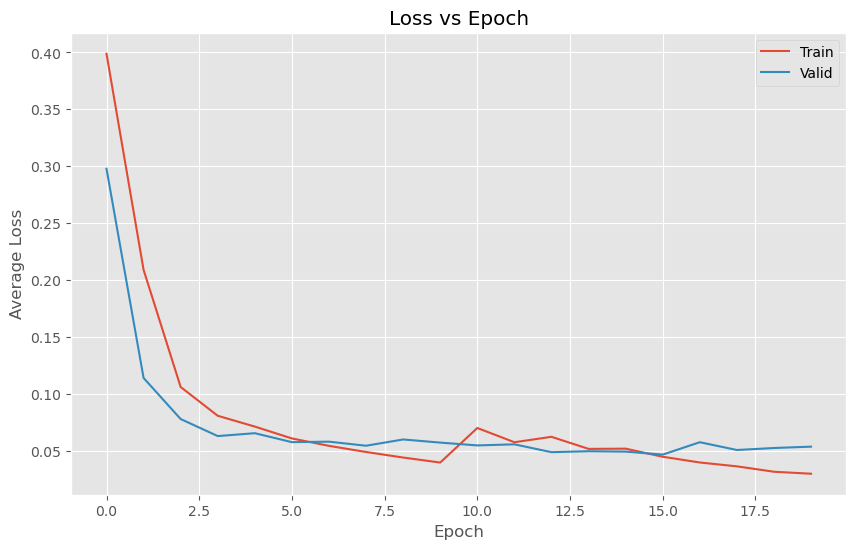

In [38]:
# # Plot losses
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

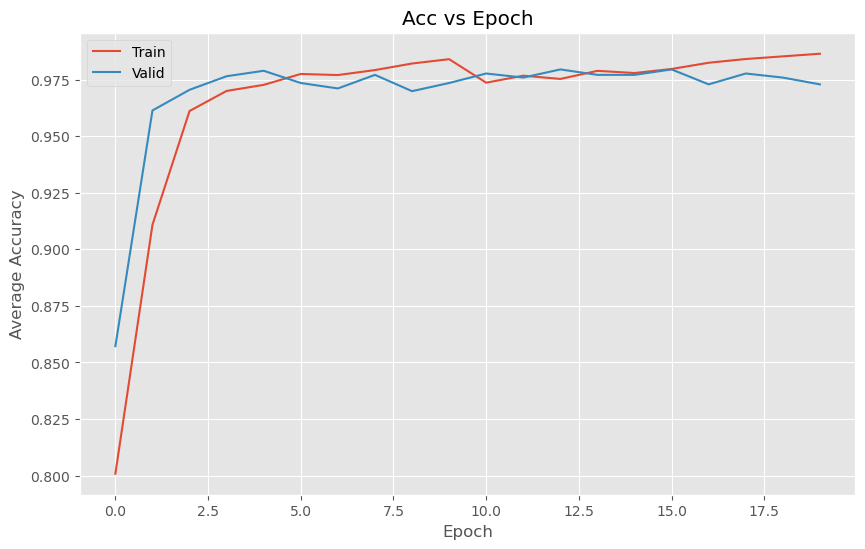

In [39]:
# Plot accuracy
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.title('Acc vs Epoch')
plt.show()

### Evaluation

Testing Loop

In [40]:
def test_model(model, dataloader):
    model.eval()
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    
    y_scores = []
    labels_list = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, features, labels = batch[0], batch[1], batch[2].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            features = features.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.int64)
            
            labels_list.append(labels.detach().cpu().numpy())
            
            outputs = model(inputs, features)
            outputs = outputs.sigmoid()
            
            y_scores += [outputs.detach().cpu()]
            
        y_scores = torch.cat(y_scores).cpu().numpy()
        
    return y_scores, labels_list


## y_scores contains all the model predictions (the probabilites of each class)
## labels_list contains the actual values

In [41]:
y_scores, labels_list = test_model(model_ft, test_dl)

100%|██████████| 29/29 [00:06<00:00,  4.65it/s]


In [42]:
def flatten(my_list):
    flattened_list = [x for sublist in my_list for x in sublist]
    return flattened_list

In [45]:
labels = np.array(flatten(labels_list))
labels.shape, y_scores.shape

((1800,), (1800, 1))

ROC Curve

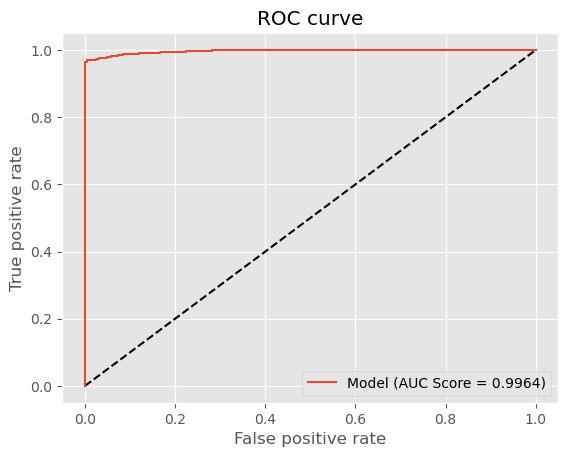

In [58]:
y_test = labels # ground_truth
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (AUC Score = {:.4f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('lens_finding_ROC-Curve.png')
plt.show()